<a href="https://colab.research.google.com/github/NinaOmani/S2S_Precipitation_Forecasting/blob/main/B_Analog_S2S_PRCP_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas numpy scikit-learn scipy matplotlib
!pip install gdown

In [ ]:
import os
import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from scipy.spatial.distance import mahalanobis

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define hindcast and historic years
hindcast_years = list(range(1981, 2023))  # 1981 to 2023 (last update: Feb 2024)
historic_years = list(range(1985, 2022))  # 1985 to 2022

In [ ]:
model_dir = "ECMWF"
os.makedirs(model_dir, exist_ok=True)

In [ ]:
# Define a region
regions = ["AZ_West", "AZ_East", "NM_South", "NM_North"]

In [ ]:
# Standardization function
def standardize(series):
    return (series - series.mean(skipna=True)) / series.std(skipna=True)

# Function to prepare historic and forecast data
def prepare_data(features, years, unique_seasons, obs=True):
    """
    Filters and selects data for kNN analysis.

    Parameters:
    - features: DataFrame containing all features.
    - years: List of years to include.
    - unique_seasons: List of seasons to include.
    - obs: Boolean; True = observed data, False = forecasted data.

    Returns:
    - Prepared DataFrame with selected features.
    """

    if obs:
        select_cols = ["year", "season"] + [
            col for col in features.columns if col.endswith(("_obs", ".obs")) or "_obs" in col
        ]
    else:
        select_cols = ["lead_month", "year", "season"] + [
            col for col in features.columns if col.endswith(("_for", ".for")) or "_for" in col
        ]

    df_filtered = features[features["year"].isin(years) & features["season"].isin(unique_seasons)][select_cols].dropna().drop_duplicates()

    return df_filtered  # <- Correctly indented return statement

# Function to find analogs using kNN
def find_analogs_for_month_and_lead(historic_data, forecast_data, season, lead_month, K=5):
    """
    Performs kNN search for analog years.

    Parameters:
    - historic_data: DataFrame containing observed historical data.
    - forecast_data: DataFrame containing forecasted data.
    - season: The season for analysis.
    - lead_month: The lead month for forecasts.
    - K: Number of analogs to retrieve.

    Returns:
    - DataFrame of analog years with distances and weights.
    """
    results = []

    # Filter forecast data for specific season and lead month
    forecast_data = forecast_data[(forecast_data["season"] == season) & (forecast_data["lead_month"] == lead_month)]

    for _, forecast_row in forecast_data.iterrows():
        # Exclude the forecast year from historic data
        historic_filtered = historic_data[(historic_data["season"] == season) & (historic_data["year"] != forecast_row["year"])].dropna()

        obs_cols_historic = [col for col in historic_filtered.columns if col.endswith("_obs")]

        # Ensure only numeric data is used
        if not all(np.issubdtype(historic_filtered[col].dtype, np.number) for col in obs_cols_historic):
            raise ValueError("Non-numeric data found in historic_filtered.")

        # Prepare feature matrices for kNN
        historic_matrix = historic_filtered[obs_cols_historic].to_numpy()
        forecast_matrix = forecast_row[[col for col in forecast_row.index if col.endswith("_for")]].to_numpy().reshape(1, -1)

        # Ensure feature dimension consistency
        if historic_matrix.shape[1] != forecast_matrix.shape[1]:
            raise ValueError("Number of features in historic and forecast data does not match.")

        # Perform kNN search
        knn = NearestNeighbors(n_neighbors=min(K, len(historic_filtered)), metric="euclidean")
        knn.fit(historic_matrix)
        distances, indices = knn.kneighbors(forecast_matrix)

        # Collect analog years and weights
        unique_analogs = []
        analog_distances = []
        analog_weights = []

        for j in range(len(indices[0])):
            analog_year = historic_filtered.iloc[indices[0][j]]["year"]
            if analog_year not in unique_analogs:
                unique_analogs.append(analog_year)
                analog_distances.append(distances[0][j])
                analog_weights.append(1 / (distances[0][j] + 1e-5))  # Avoid division by zero

            if len(unique_analogs) == K:
                break

        # Store results
        for j in range(len(unique_analogs)):
            results.append({
                "ForecastYear": forecast_row["year"],
                "season": season,
                "lead_month": lead_month,
                "AnalogYear": unique_analogs[j],
                "Distance": analog_distances[j],
                "Weight": analog_weights[j],
                "Rank": j + 1
            })

    return pd.DataFrame(results)

# **Start Prediction**

In [ ]:
'''
# Load the newly uploaded dataset to verify and apply the fix
Predictors_filled = pd.read_csv("Predictors.csv")

# Add ENSO indices to the list of columns to fill
antecedent_cols_extended = [
    "antecedent_3m.for", "antecedent_2m.for", "antecedent_1m.for",
    "antecedent_3m.obs", "antecedent_2m.obs", "antecedent_1m.obs",
    "ant_dsst3.4.for", "ant_mei.for", "ant_soi.for",
    "ant_dsst3.4.obs", "ant_mei.obs", "ant_soi.obs"
]

agg_season_mapping = {
    "JJ": "Jun", "JA": "Jun", "AS": "Aug", "SO": "Sep",
    "JJA": "Jun", "JAS": "Jul", "ASO": "Aug", "JASO": "Jul", "JJASO": "Jun"
}

# Re-apply filling logic for these extended columns
for agg_season, base_month in agg_season_mapping.items():
    for (region, year), group in Predictors_filled.groupby(["region", "year"]):
        agg_mask = (Predictors_filled["region"] == region) & (Predictors_filled["year"] == year) & (Predictors_filled["season"] == agg_season)
        base_mask = (Predictors_filled["region"] == region) & (Predictors_filled["year"] == year) & (Predictors_filled["season"] == base_month)

        if agg_mask.any() and base_mask.any():
            for col in antecedent_cols_extended:
                if Predictors_filled.loc[agg_mask, col].isna().all() and Predictors_filled.loc[base_mask, col].notna().any():
                    Predictors_filled.loc[agg_mask, col] = Predictors_filled.loc[base_mask, col].values[0]

Predictors_filled.to_csv("Predictors_filled.csv", index=False)
'''

In [ ]:

import pandas as pd
# Load predictor file
Predictors_filled2 = pd.read_csv("Predictors_filled.csv")

# Define experiment
experiment = "WT"
#experiment = "ENSO"
#experiment = "Q"
#experiment = "TCLW"
experiment = "TPRATE"
#experiment = "TCWV"
#experiment = "Antecedent Precipitation Only"
experiment = "Antecedent Precipitation WT"

# Define shared base columns
base_columns = ["region", "season", "year", "lead_month", "avgPCP_mmDay"]

# Define predictor groups by experiment
predictors_by_experiment = {
    "WT": [
        "sumMonsoon", "sumDry"
    ],
    "ENSO": [
        "ant_mei", "ant_soi", "ant_dsst3.4"
    ],
    "Q": [
        "sumq"
    ],
    "TCLW": [
        "sumtclw"
    ],
    "TPRATE": [
        "sumtprate"
    ],
    "TCWV": [
        "sumtcwv"
    ],
    "Antecedent Precipitation Only": [
        "antecedent_1m", "antecedent_2m", "antecedent_3m"
    ],
    "Antecedent Precipitation WT": [
        "antecedent_1m", "antecedent_2m", "antecedent_3m",
        "sumMonsoon", "sumDry"
    ]
}

# Get predictor base names for the selected experiment
predictors1 = predictors_by_experiment.get(experiment, [])

# Expand predictors1 to include both .obs and .for versions
predictor_columns = []
for var in predictors1:
    predictor_columns.extend([f"{var}_obs", f"{var}_for"])

# Final feature selection
selected_columns = base_columns + predictor_columns
features = Predictors_filled2[selected_columns].copy()

# Define standardization function
def standardize(x):
    return (x - x.mean()) / x.std() if x.std() != 0 else 0

# Identify columns to standardize
std_cols = [c for c in features.columns if c.endswith("_for") or c.endswith("_obs")]

# Apply group-based standardization
for col in std_cols:
    group_cols = ["region", "season"] if col.endswith("_for") else ["region", "season"]
    features[f"sd_{col}"] = features.groupby(group_cols)[col].transform(
        lambda x: standardize(x) if not x.isna().all() else x
    )


In [ ]:
def perform_analog_analysis_season(features, current_region, hindcast_years, historic_years, K, model_dir):
    """
    Performs kNN-based analog analysis for seasonal climate prediction.

    Parameters:
    - features (DataFrame): The dataset.
    - current_region (str): The region being analyzed.
    - hindcast_years (list): Years for forecast data.
    - historic_years (list): Years for historic data.
    - K (int): Number of closest analog years.
    - model_dir (str): Directory to save results.

    Returns:
    - DataFrame: Data with matched analog years.
    """

    unique_seasons = features["season"].unique()
    features_reg = features[features["region"] == current_region].copy()

    historic_data = prepare_data(features_reg, list(map(int, historic_years)), unique_seasons, obs=True)
    forecast_data = prepare_data(features_reg, hindcast_years, unique_seasons, obs=False)

    analog_years = pd.concat(
        [find_analogs_for_month_and_lead(historic_data, forecast_data, season, lead_month, K)
         for season in forecast_data["season"].unique()
         for lead_month in forecast_data["lead_month"].astype(float).unique()],
        ignore_index=True
    )

    analog_years["year"] = analog_years["ForecastYear"].astype(int)
    analog_years["season"] = analog_years["season"].astype(str)
    analog_years["Region"] = current_region

    analog_years.to_csv(f"{model_dir}/5.Analog_years_{current_region}.csv", index=False)

    data_with_analog = analog_years.merge(features_reg, on=["year", "season", "lead_month"], how="left").dropna(subset=["AnalogYear"])
    data_with_analog["ID"] = data_with_analog.index

    #data_with_analog.to_csv(f"{model_dir}/6.data_with_analog_{current_region}.csv", index=False)
    return data_with_analog

In [ ]:
# Initialize an empty DataFrame to store combined results
combined_results = pd.DataFrame()

# Iterate over each region and perform analog analysis
for current_region in regions:
    print(f"Processing region: {current_region}")

    # Perform analog analysis
    current_results = perform_analog_analysis_season(
        features, current_region, hindcast_years, historic_years, K, model_dir)

    combined_results = pd.concat([combined_results, current_results], ignore_index=True)

#combined_results.to_csv(f"{model_dir}/combined_results.csv", index=False)

Processing region: NM_North
Processing region: NM_South
Processing region: AZ_East
Processing region: AZ_West


In [ ]:
# This step may take several minutes
combined_results = combined_results.sort_values(by=["ID"])

combined_results["AnalogObservation"] = None

combined_results["AnalogYear"] = combined_results["AnalogYear"].astype(int)
combined_results["ForecastYear"] = combined_results["ForecastYear"].astype(int)

# Iterate through each row to assign AnalogObservation
for index, row in combined_results.iterrows():
    # Extract values for lookup
    current_analog_year = row["AnalogYear"]
    current_season = row["season"]
    current_region = row["Region"]

    # Find matching observation
    match = combined_results[
        (combined_results["ForecastYear"] == current_analog_year) &
        (combined_results["season"] == current_season) &
        (combined_results["Region"] == current_region)
    ]

    # If a match is found, assign the first available avgPCP_mmDay value
    if not match.empty:
        combined_results.at[index, "AnalogObservation"] = match.iloc[0]["avgPCP_mmDay"]

In [ ]:
output_file = os.path.join(model_dir, "7.Data_with_analog_all_regions.csv")
combined_results.to_csv(output_file, index=False)
print(f"✅ Saved: {output_file}")

✅ Saved: ECMWF/7.Data_with_analog_all_regions.csv


In [ ]:
# Load the analog years and forecasted streamflow along with historical streamflow
file_path = os.path.join(model_dir, "7.Data_with_analog_all_regions.csv")
data_with_analog = pd.read_csv(file_path)

Best_Analog = True  # Choosing whether to export only the best analog
# If only the best analog is needed, filter for Rank == 1
if Best_Analog:
    data_with_analog = data_with_analog[data_with_analog["Rank"] == 1]

print(f"✅ Data loaded successfully. Shape: {data_with_analog.shape}")

✅ Data loaded successfully. Shape: (9072, 33)


In [ ]:
# Compute the weighted average analog precipitation

data_with_analog['Weighted_Avg_AnalogPcp'] = (
    data_with_analog.groupby(['Region', 'ForecastYear', 'season', 'lead_month'])['AnalogObservation']
    .transform(lambda x: (x * data_with_analog.loc[x.index, 'Weight']).sum() / data_with_analog.loc[x.index, 'Weight'].sum())
)

# Filter out rows where Weighted_Avg_AnalogPcp is NaN
data_with_analog_WA = data_with_analog.dropna(subset=["Weighted_Avg_AnalogPcp"])
data_with_analog_WA = data_with_analog_WA.drop(columns=["AnalogObservation"])

data_with_analog_WA.to_csv(os.path.join(model_dir, f"8.data_with_analog_WA_{experiment}.csv"))
print(f"✅ Filtered dataset saved successfully: {output_file}")

✅ Filtered dataset saved successfully: ECMWF/7.Data_with_analog_all_regions.csv


In [ ]:
# Define the forecast evaluation period
year_start_metrics = 1993
year_end_metrics = 2023

In [ ]:
# Filter the dataset for the specified forecast years and best-ranked analog (Rank == 1) to remove duplicated rows
data_with_analog_WA_filtered = data_with_analog_WA[
    (data_with_analog_WA["ForecastYear"] >= year_start_metrics) &
    (data_with_analog_WA["ForecastYear"] <= year_end_metrics) &
    (data_with_analog_WA["Rank"] == 1)
].copy()

In [ ]:
# Define error metric functions
def mae(actual, predicted):
    """ Mean Absolute Error """
    return np.mean(np.abs(actual - predicted))

def rmse(actual, predicted):
    """ Root Mean Square Error """
    return np.sqrt(np.mean((actual - predicted) ** 2))

def mape(actual, predicted):
    """ Mean Absolute Percentage Error """
    return np.mean(np.abs((actual - predicted) / actual)) * 100

def smape(actual, predicted):
    """ Symmetric Mean Absolute Percentage Error """
    return np.mean(np.abs(actual - predicted) / ((np.abs(actual) + np.abs(predicted)) / 2)) * 100

In [ ]:

# Ensure valid values and filter NaN
data_filtered = data_with_analog_WA_filtered.dropna(subset=["avgPCP_mmDay", "Weighted_Avg_AnalogPcp"]).copy()

# Calculate mean monthly evaluation metrics
Analog_evaluation_metrics_meanMonthly = data_filtered.groupby(["Region", "season", "lead_month"]).apply(
    lambda group: pd.Series({
        "MAE": mae(group["avgPCP_mmDay"], group["Weighted_Avg_AnalogPcp"]),
        "RMSE": rmse(group["avgPCP_mmDay"], group["Weighted_Avg_AnalogPcp"]),
        "MAPE": mape(group["avgPCP_mmDay"], group["Weighted_Avg_AnalogPcp"]),
        "sMAPE": smape(group["avgPCP_mmDay"], group["Weighted_Avg_AnalogPcp"]),
    })
).reset_index()

<ipython-input-116-1a99f97b6b96>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  Analog_evaluation_metrics_meanMonthly = data_filtered.groupby(["Region", "season", "lead_month"]).apply(


In [ ]:
output_file = os.path.join(model_dir, f"Analog_evaluation_metrics_meanMonthly_{experiment}.csv")
Analog_evaluation_metrics_meanMonthly.to_csv(output_file, index=False)

In [ ]:
# output plots
plotdir = os.path.join(model_dir, "plot_output")
os.makedirs(plotdir, exist_ok=True)
print(f"✅ Plot directory created (or already exists): {plotdir}")

✅ Plot directory created (or already exists): ECMWF/plot_output


<ipython-input-33-b41dc0a593a8>:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Blues')
<ipython-input-33-b41dc0a593a8>:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0, 0.9, 0.95])


✅ Saved plot: ECMWF/plot_output/Precip_NM_North_['sumMonsoon', 'sumDry'].png


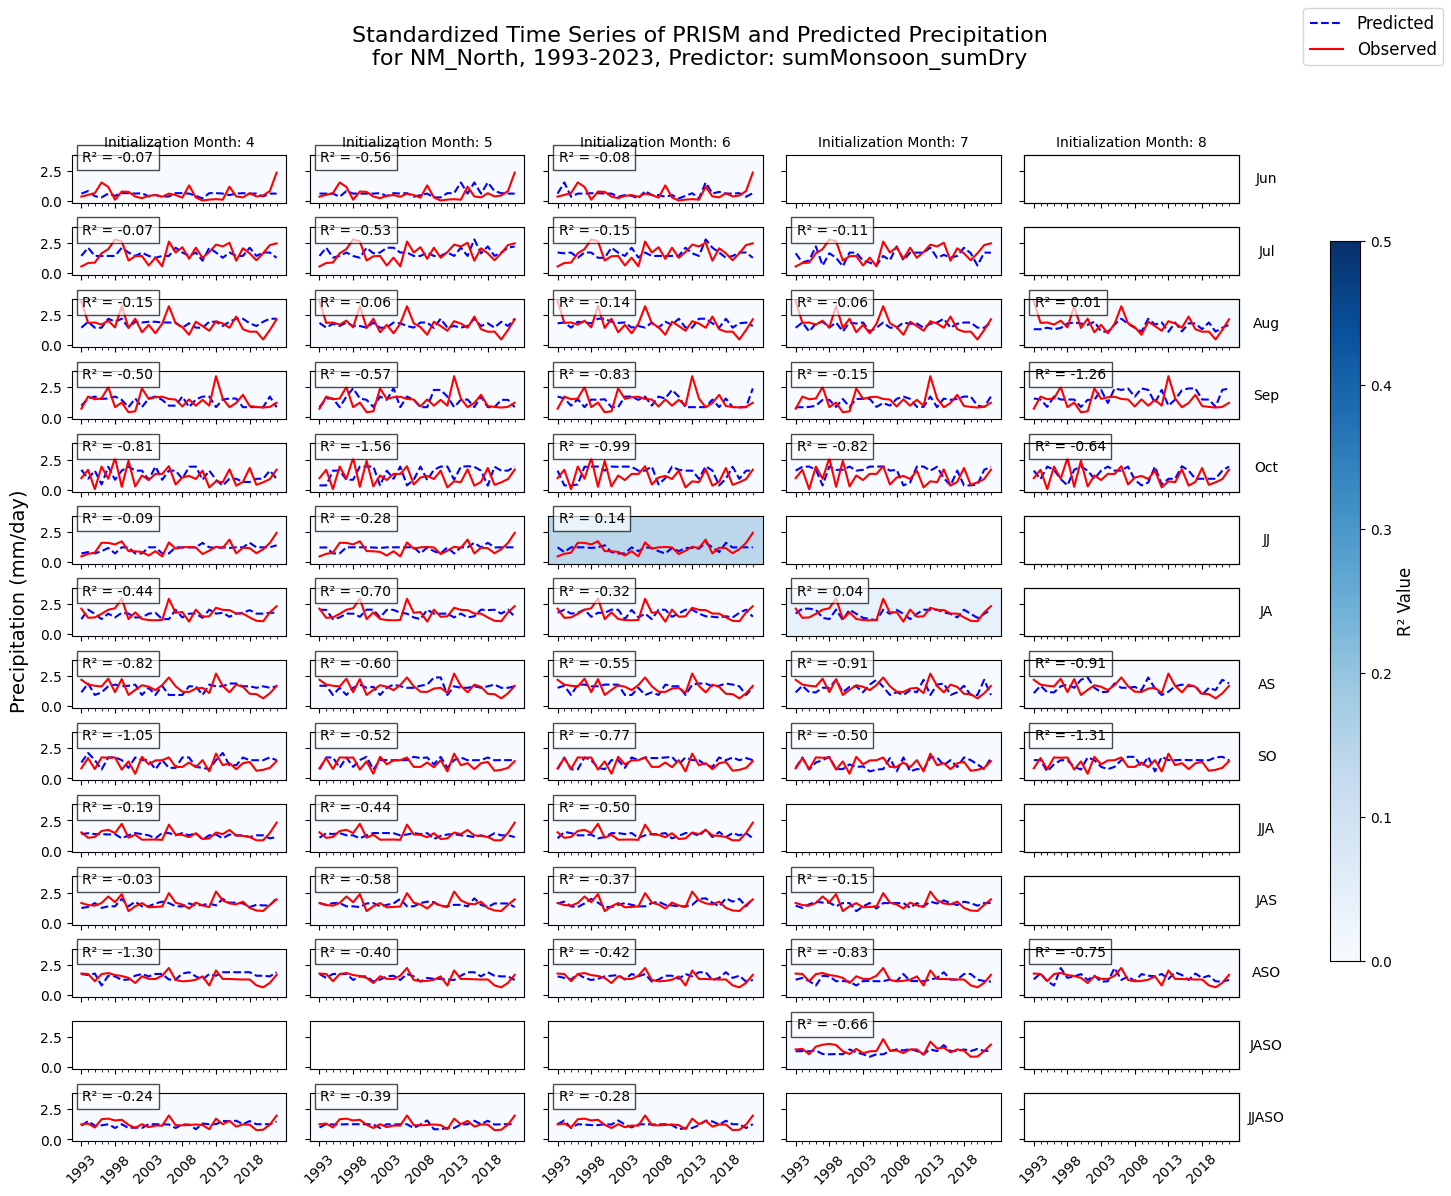

<ipython-input-33-b41dc0a593a8>:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0, 0.9, 0.95])


✅ Saved plot: ECMWF/plot_output/Precip_NM_South_['sumMonsoon', 'sumDry'].png


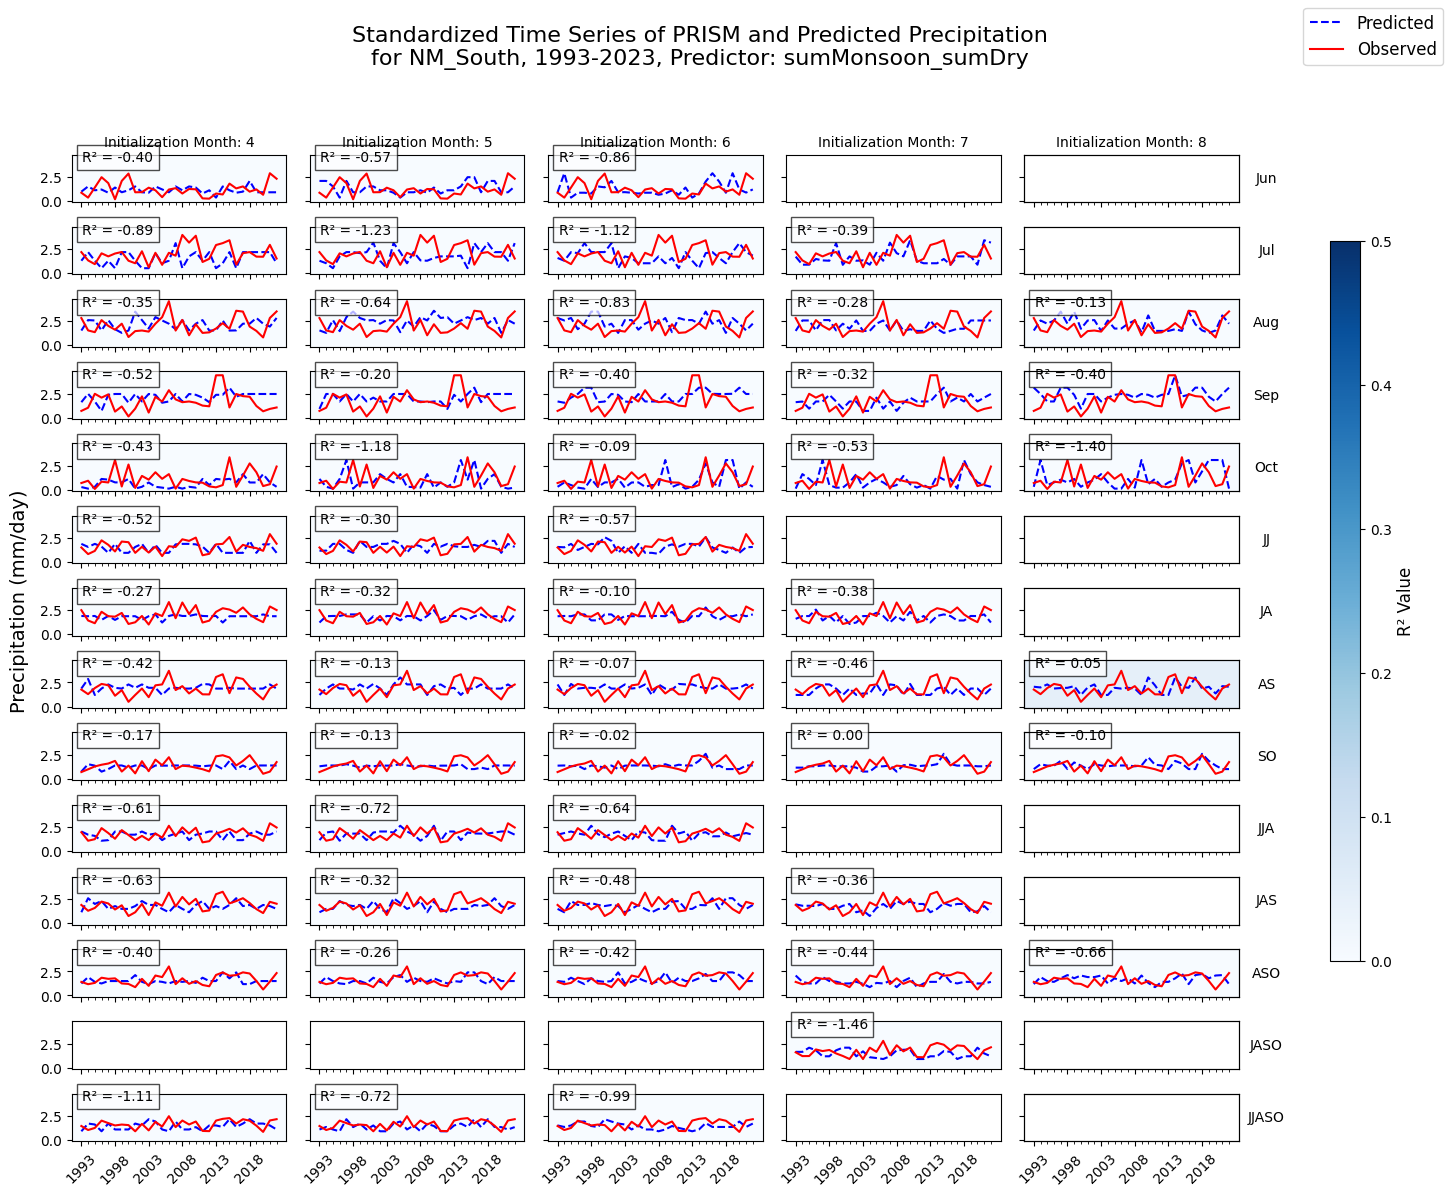

<ipython-input-33-b41dc0a593a8>:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0, 0.9, 0.95])


✅ Saved plot: ECMWF/plot_output/Precip_AZ_East_['sumMonsoon', 'sumDry'].png


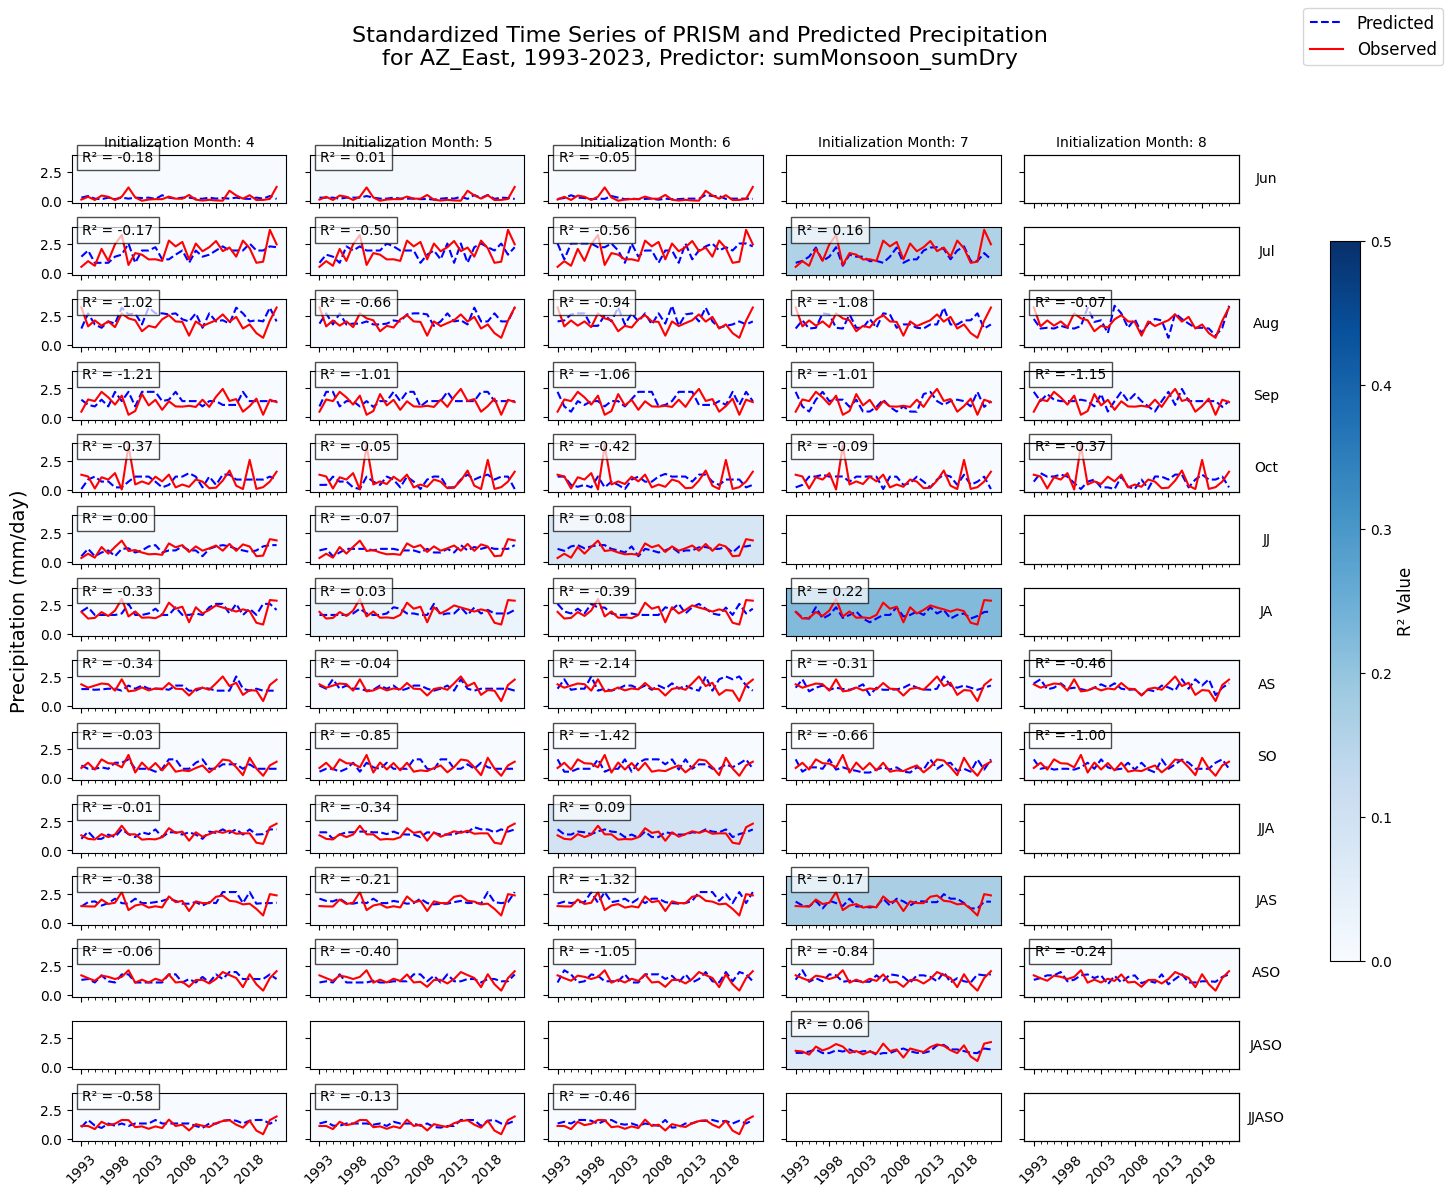

<ipython-input-33-b41dc0a593a8>:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0, 0.9, 0.95])


✅ Saved plot: ECMWF/plot_output/Precip_AZ_West_['sumMonsoon', 'sumDry'].png


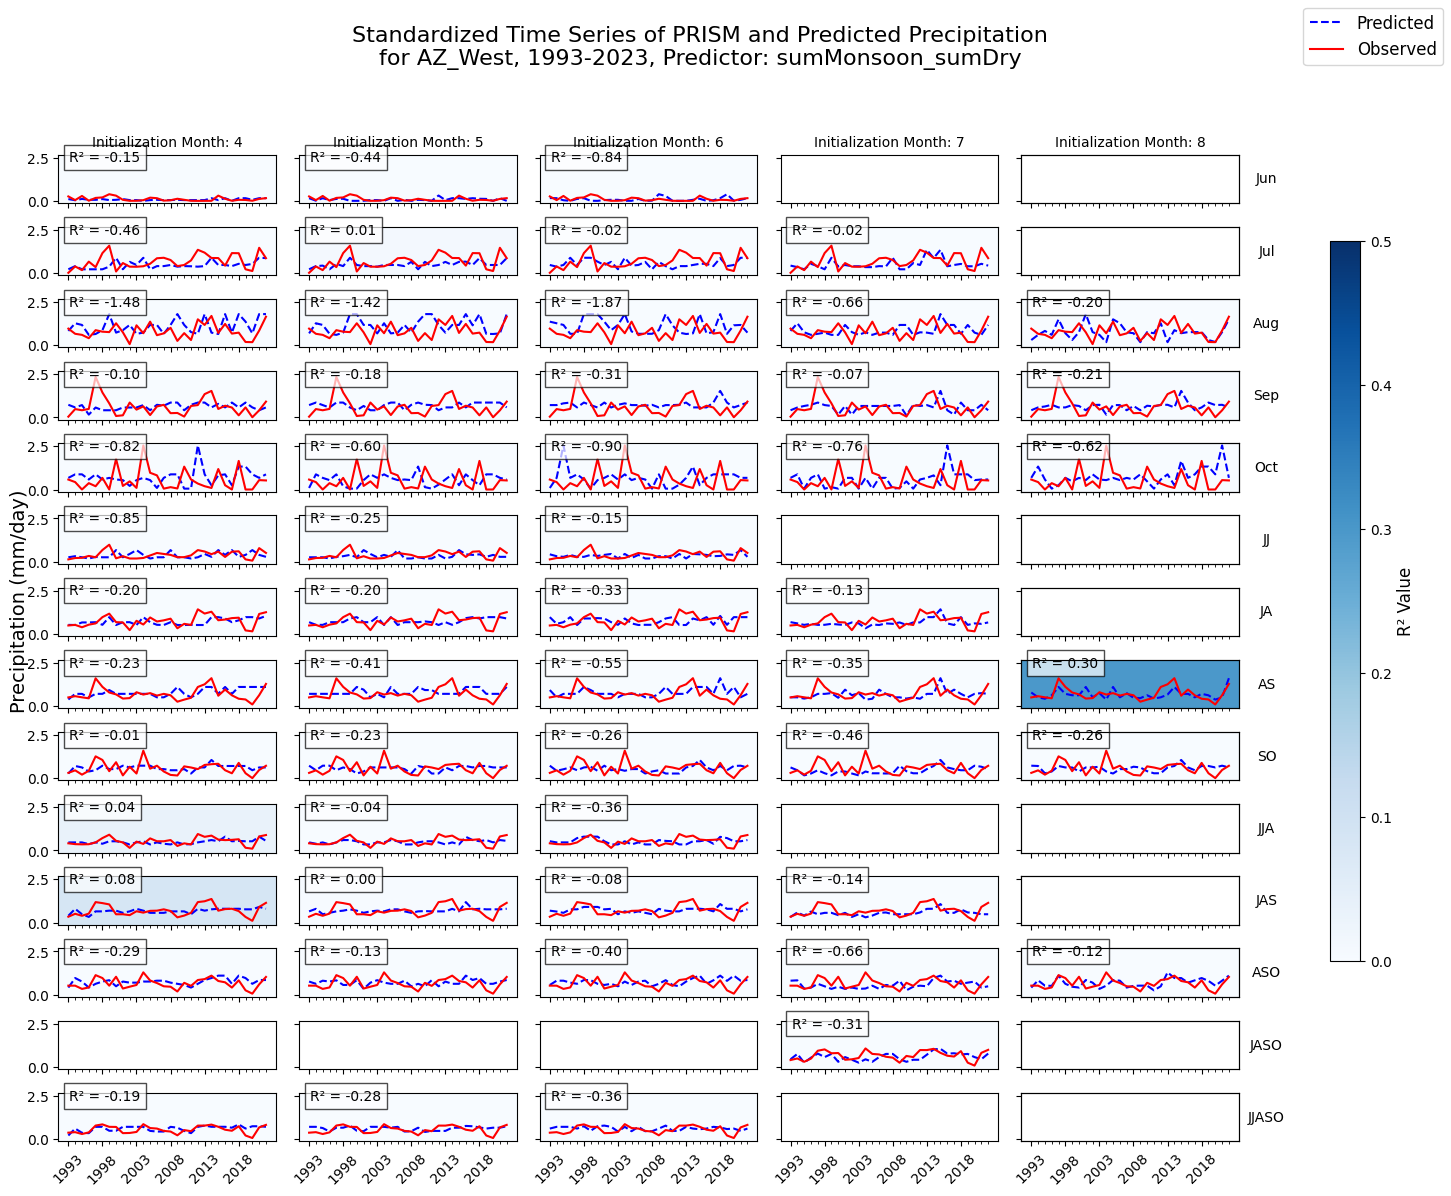

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from matplotlib import cm

# Custom season order
custom_season_order = ['Jun', 'Jul', 'Aug', 'Sep', 'Oct',
                       'JJ', 'JA', 'AS', 'SO',
                       'JJA', 'JAS', 'ASO', 'JASO', 'JJASO']

df_standardized = data_with_analog_WA_filtered.copy()

# Standardize precipitation values per region and season
scaler = StandardScaler()
for (region, season), group in data_with_analog_WA_filtered.groupby(["region", "season"]):
    indices = group.index
    df_standardized.loc[indices, "avgPCP_mmDay_norm"] = scaler.fit_transform(group[["avgPCP_mmDay"]])
    df_standardized.loc[indices, "Weighted_Avg_AnalogPcp_norm"] = scaler.fit_transform(group[["Weighted_Avg_AnalogPcp"]])

# Define lead months and season order
lead_months = sorted(df_standardized["lead_month"].unique())
season_order = [s for s in custom_season_order if s in df_standardized["season"].unique()]

regions = df_standardized["region"].unique()

# Define colormap and normalization for R² values
cmap = cm.get_cmap('Blues')
norm = plt.Normalize(0, 0.5)

# Generate and save plots for each region
for region in regions:
    region_df = df_standardized[df_standardized["region"] == region]

    # Define figure size
    fig, axes = plt.subplots(nrows=len(season_order), ncols=len(lead_months),
                             figsize=(15, 12), sharex=True, sharey=True)

    fig.suptitle(
        f"Standardized Time Series of PRISM and Predicted Precipitation\n"
        f"for {region}, {year_start_metrics}-{year_end_metrics}, Predictor: {'_'.join(predictors1)}",
        fontsize=16
    )

    # Iterate over seasons and lead months
    for i, season in enumerate(season_order):
        for j, lead_month in enumerate(lead_months):
            ax = axes[i, j] if len(season_order) > 1 else axes[j]  # Handle case of single row

            subset = region_df[(region_df["season"] == season) & (region_df["lead_month"] == lead_month)]

            if not subset.empty:
                subset = subset.dropna(subset=["avgPCP_mmDay", "Weighted_Avg_AnalogPcp"])
                subset["avgPCP_mmDay"] = pd.to_numeric(subset["avgPCP_mmDay"])
                subset["Weighted_Avg_AnalogPcp"] = pd.to_numeric(subset["Weighted_Avg_AnalogPcp"])

                # Compute R² score
                r2 = r2_score(subset["avgPCP_mmDay"], subset["Weighted_Avg_AnalogPcp"])
                #r2 = np.corrcoef(avgPCP_mmDay, Weighted_Avg_AnalogPcp)[0, 1] ** 2
                # Set background color based on updated R² range (white to blue transition)
                ax.set_facecolor(cmap(norm(r2)))

                # Primary y-axis: Standardized precipitation
                ax.plot(subset["year"], subset["Weighted_Avg_AnalogPcp"], label="Predicted", color="blue", linestyle="--")
                ax.plot(subset["year"], subset["avgPCP_mmDay"], label="Observed", color="red")

                # Display R² score
                ax.text(0.05, 0.85, f"R² = {r2:.2f}", transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

                # Set major ticks (labels every 5 years)
                years = subset["year"].unique()
                ax.set_xticks(years[::5])
                ax.set_xticklabels(years[::5], rotation=45)

                # Set minor ticks (tick marks every 1 year)
                ax.set_xticks(np.arange(years.min(), years.max() + 1, 1), minor=True)

            else:
                ax.set_xticks(np.arange(df_standardized["year"].min(), df_standardized["year"].max() + 1, 5))
                ax.set_xticklabels(np.arange(df_standardized["year"].min(), df_standardized["year"].max() + 1, 5), rotation=45)

            # Ensure all far-right subplots have the season label on secondary y-axis
            if j == len(lead_months) - 1:
                ax2 = ax.twinx()
                ax2.set_ylabel(season, fontsize=10, rotation=0, labelpad=20, verticalalignment='center')
                ax2.set_yticks([])  # Hide y-ticks

            # Show lead month only on the top row subplots
            if i == 0:
                ax.set_title(f"Initialization Month: {int(lead_month)}", fontsize=10)

    # Add a single y-axis label for the entire figure
    fig.text(0.04, 0.5, "Precipitation (mm/day)", va='center', rotation='vertical', fontsize=14)

    # Add a legend for the lines
    handles = [plt.Line2D([0], [0], color="blue", linestyle="--", label="Predicted"),
               plt.Line2D([0], [0], color="red", label="Observed")]
    fig.legend(handles=handles, loc="upper right", fontsize=12)

    # Add colorbar for R² values with updated range (0 to 0.5, white to blue)
    cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
    cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
    cbar.set_label("R² Value", fontsize=12)
    cbar.set_ticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])

    plt.tight_layout(rect=[0.05, 0, 0.9, 0.95])

    # **Save and Show the Figure**
    plot_filename = f"{plotdir}/Precip_{region}_{predictors1}.png"
    plt.savefig(plot_filename, dpi=300, bbox_inches="tight")
    print(f"✅ Saved plot: {plot_filename}")

    plt.show()  # Show the figure after saving

# **Combine error metrics from all experiments**


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
from matplotlib import cm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from scipy.spatial.distance import mahalanobis

In [ ]:
# Define file paths
file_paths = {
    "tprate": "8.data_with_analog_WA_TPRATE.csv",
    "SOI_MEI_dSST3.4": "8.data_with_analog_WA_ENSO.csv",
    "WT": "8.data_with_analog_WA_WT.csv",
    "anteced_precip": "8.data_with_analog_WA_Antecedent Precipitation Only.csv",
    "anteced_precip_WT": "8.data_with_analog_WA_Antecedent Precipitation WT.csv",
    "q": "8.data_with_analog_WA_Q.csv",
    "tclw": "8.data_with_analog_WA_TCLW.csv"
    #"tcwv": "8.data_with_analog_WA_tcwv.csv"
}

# Extended mapping for sorting seasons (unchanged)
season_to_month_extended = {
    'JJA': 7, 'JAS': 8,
    'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'ASO' : 8,
    'AS': 8, 'JA': 7, 'JJ': 6, 'SO': 9, 'JJASO': 7, 'JJA': 6, 'JASO': 8
}

# Load data
dataframes = {
    name: pd.read_csv(os.path.join(model_dir, path))
    for name, path in file_paths.items()
}


# Filter and compute error metrics
metrics_summary = []

def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

for name, df in dataframes.items():
    if {'avgPCP_mmDay', 'Weighted_Avg_AnalogPcp', 'lead_month', 'region', 'ForecastYear'}.issubset(df.columns):
        # Filter for evaluation period
        df = df[(df["ForecastYear"] >= year_start_metrics) & (df["ForecastYear"] <= year_end_metrics)]
        df = df.dropna(subset=["avgPCP_mmDay", "Weighted_Avg_AnalogPcp"])

        grouped = df.groupby(["region", "season", "lead_month"])

        for (region, season, lead), group_data in grouped:
            y_true = group_data["avgPCP_mmDay"]
            y_pred = group_data["Weighted_Avg_AnalogPcp"]
            mse = mean_squared_error(y_true, y_pred)
            rmse = np.sqrt(mse)
            smape_val = smape(y_true, y_pred)
            r2 = r2_score(y_true, y_pred)

            metrics_summary.append({
                "experiment": name,
                "region": region,
                "season": season,
                "lead_month": lead,
                "rmse": rmse,
                "sMAPE": smape_val,
                "r2": r2
            })

metrics_df = pd.DataFrame(metrics_summary)


In [ ]:

# Your season-to-month mapping
month_to_num = {
    'JJA': 7, 'JAS': 8,
    'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'ASO': 8,
    'AS': 8, 'JA': 7, 'JJ': 6, 'SO': 9, 'JJASO': 7, 'JASO': 8
}

# Calculate lead_time directly using mapping
metrics_df['lead_time'] = metrics_df.apply(
    lambda row: month_to_num.get(row['season'], np.nan) - row['lead_month'],
    axis=1
)

# Handle negative values by wrapping around the calendar
metrics_df['lead_time'] = metrics_df['lead_time'].apply(lambda x: x + 12 if x < 0 else x)
metrics_df.rename(columns={"Region": "region", "R2": "r2"}, inplace=True)
metrics_df["r2"] = pd.to_numeric(metrics_df["r2"], errors="coerce")

output_path = "9.Analog_Error_Metrics_all_experiment.csv"
metrics_df.to_csv(output_path, index=False)
